In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp

import multihist as mh
import appletree as apt
from appletree import utils
from appletree import randgen
from appletree import hist
from appletree.context import ERBand

In [2]:
utils.set_gpu_memory_usage(0.2)

In [3]:
tree = ERBand()

In [4]:
# it will define a function called <func_name>
tree.deduce(func_name='er_sim')
tree.compile()

par_manager = tree.par_manager

In [5]:
batch_size = int(1e6)

# Define binning and posterior

In [6]:
data = pd.read_csv('./appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv')
x_bins, y_bins = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[1e2, 1e4]
)

In [7]:
obs = hist.make_hist_irreg_bin_2d(data[['cs1', 'cs2']].to_numpy(), x_bins, y_bins, weights=np.ones(len(data)))

In [8]:
def log_posterior(pars):
    par_manager.set_parameter_fit_from_array(pars)
    
    key = randgen.get_key()
    key, (cs1, cs2, eff) = er_sim(key, batch_size, tree.parameters)
    mod = hist.make_hist_irreg_bin_2d(jnp.asarray([cs1, cs2]).T, x_bins, y_bins, weights=eff)
    mod = mod + 1 # as uncertainty
    mod = mod / jnp.sum(mod) * jnp.sum(obs)
    
    log_likelihood = float(jnp.sum(obs * jnp.log(mod) - mod))
    log_prior = par_manager.log_prior
    
    return log_likelihood + log_prior

# Fit

In [9]:
import emcee

In [10]:
nwalkers = 200
ndim = len(par_manager.parameter_fit_array)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

p0 = []
for _ in range(nwalkers):
    par_manager.sample_init()
    p0.append(par_manager.parameter_fit_array)
    
sampler.run_mcmc(p0, 100, progress=True)

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


State([[0.01334757 0.09914512 0.15329506 ... 0.68722814 0.02968488 0.28469775]
 [0.01375769 0.11378044 0.15190159 ... 0.82307514 0.02878235 0.31859546]
 [0.01368622 0.07224957 0.15341628 ... 0.79891015 0.02914509 0.21705882]
 ...
 [0.01361193 0.10044284 0.15279081 ... 0.69984562 0.03114195 0.36042589]
 [0.01342944 0.10595265 0.15114928 ... 0.75866274 0.02966038 0.25878398]
 [0.0137078  0.11366968 0.14933395 ... 0.8963709  0.03439022 0.0628151 ]], log_prob=[ 2371.81606365  2372.95401013  2371.01805432  2370.51923064
  2369.6915728   2369.40555026  2369.13018133  2371.62156959
  2372.09443605  2370.25086335  2370.6072117   2372.1955539
  2367.13620972  2373.85447994  2369.70392992  2366.13026799
  2367.2939421   2375.86268932  2365.27485862  2366.60986673
  2368.50898366  2372.37912073  2368.44425464  2367.70479535
  2367.68513349  2370.25940654  2368.84087981  2369.92223406
  2371.38318846  2369.87031685  2373.68171064  2371.02910748
  2371.73187057  2375.21242203  2373.93140662  2363.0

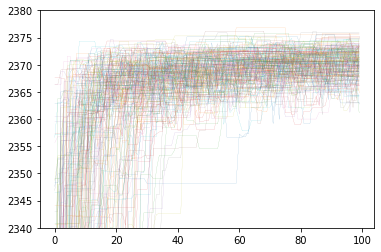

In [11]:
logp = sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.ylim(2340, 2380)
plt.show()